# Run Inference on Test Images with Custom TensorFlow2 Object Detector

In [14]:
project = "line"
!export project=$project:line

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [17]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1643309 sha256=92da15472fc729753095ee640a00161c0e96d1b5a676c0c8a7a97b2d6e750f92
  Stored in directory: /tmp/pip-ephem-wheel-cache-v0p3581c/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [18]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [19]:
# def load_image_into_numpy_array(image):
#   # BW -> RGB
#   last_axis = -1
#   image = np.expand_dims(image, last_axis)
#   dim_to_repeat = 2
#   repeats = 3
#   image = np.repeat(image, repeats, dim_to_repeat)
#   return image

In [28]:
def load_image_into_numpy_array(path, gray_mod=False):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  if gray_mod:
    image = Image.open(path)
    # BW -> RGB
    last_axis = -1
    image = np.expand_dims(image, last_axis)
    dim_to_repeat = 2
    repeats = 3
    image = np.repeat(image, repeats, dim_to_repeat)
    return image
  else:
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [21]:
%ls /content/drive/MyDrive/projects/$project/models/
models_dir = "/content/drive/MyDrive/projects/%s/models/"%project

checkpoint/  pipeline.config  saved_model/


In [22]:
#recover our saved model
pipeline_config = models_dir + "pipeline.config"
#generally you want to put the last ckpt from training in here
checkpoint_dir = models_dir + "checkpoint/"

import pathlib

filenames = list(pathlib.Path(checkpoint_dir).glob('*.index'))

filenames.sort()
print(filenames)

#generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

[PosixPath('/content/drive/MyDrive/projects/line/models/checkpoint/ckpt-0.index'), PosixPath('/content/drive/MyDrive/projects/line/models/checkpoint/ckpt-3.index')]


In [23]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [24]:
# todo should saved after train
print(pipeline_config)
print(label_map_path)

/content/drive/MyDrive/projects/line/models/pipeline.config
/content/drive/MyDrive/projects/line/data/object-detection.pbtxt


In [25]:
%mkdir /content/drive/MyDrive/projects/$project/results/

mkdir: cannot create directory ‘/content/drive/MyDrive/projects/line/results/’: File exists


Predicting Img:  0
Predicting Img:  1
Predicting Img:  2
Predicting Img:  3
Predicting Img:  4
Predicting Img:  5
Predicting Img:  6
Predicting Img:  7
Predicting Img:  8
Predicting Img:  9
Predicting Img:  10
Predicting Img:  11
Predicting Img:  12
Predicting Img:  13
Predicting Img:  14
Predicting Img:  15


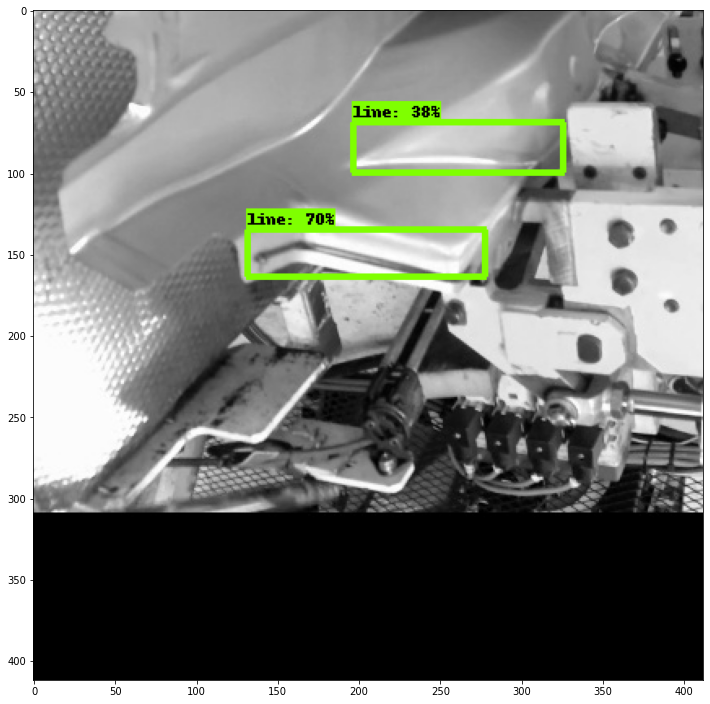

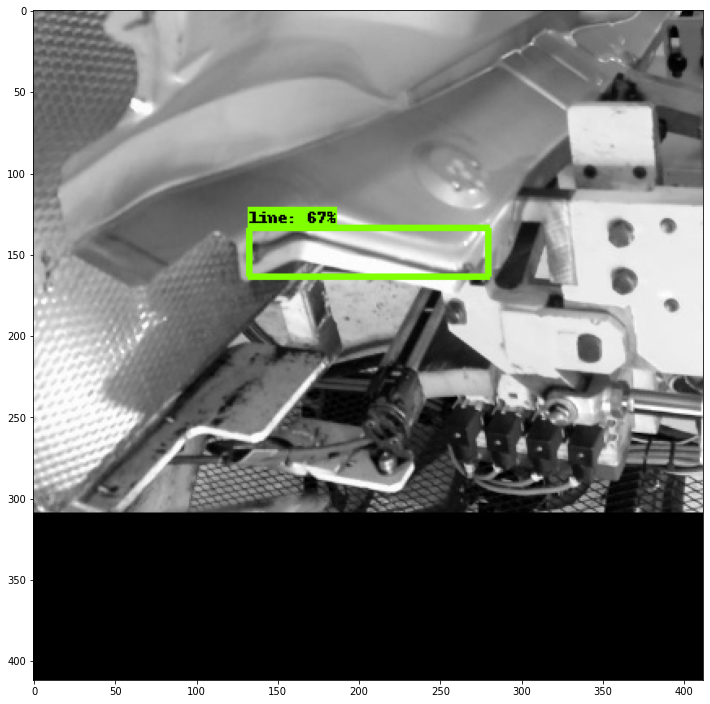

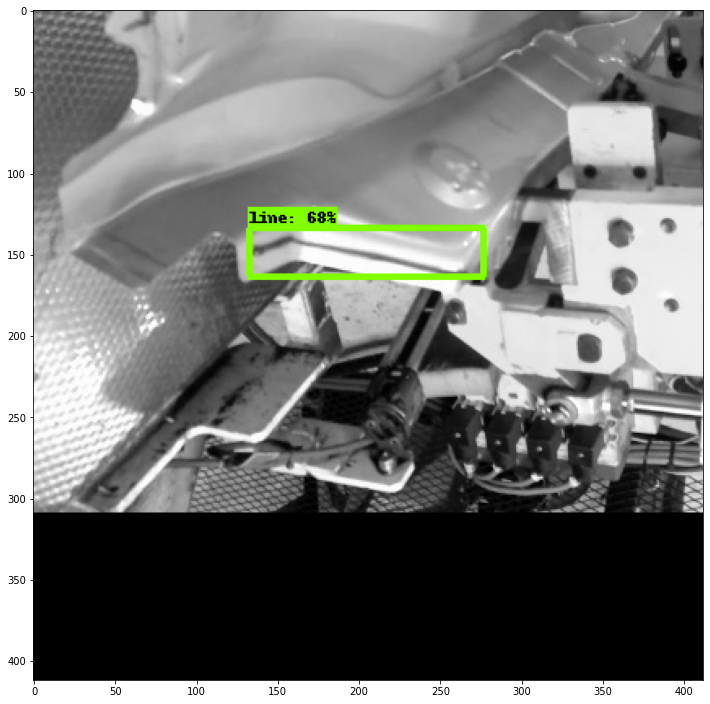

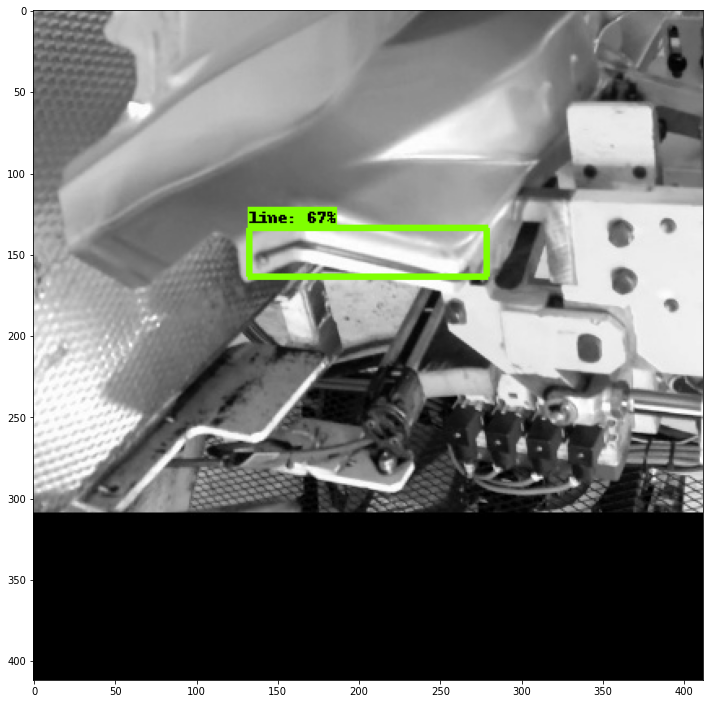

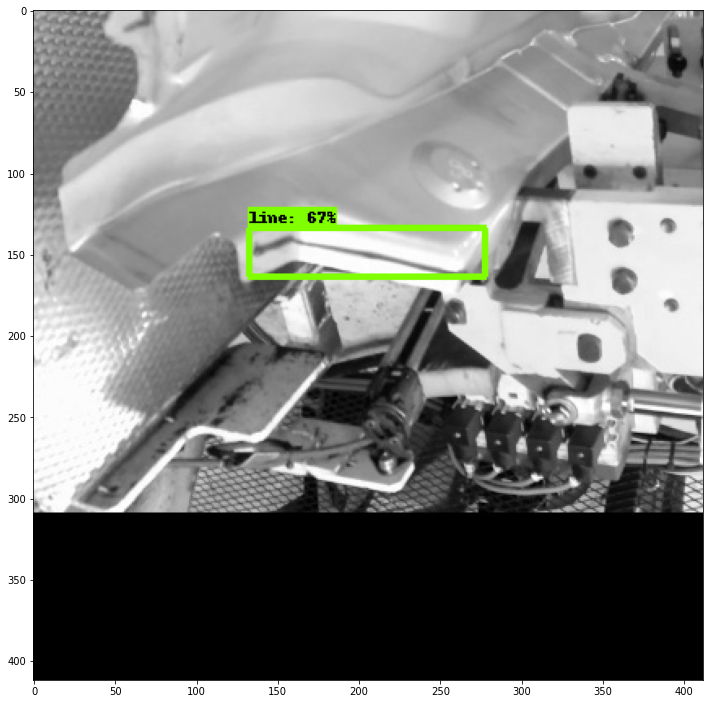

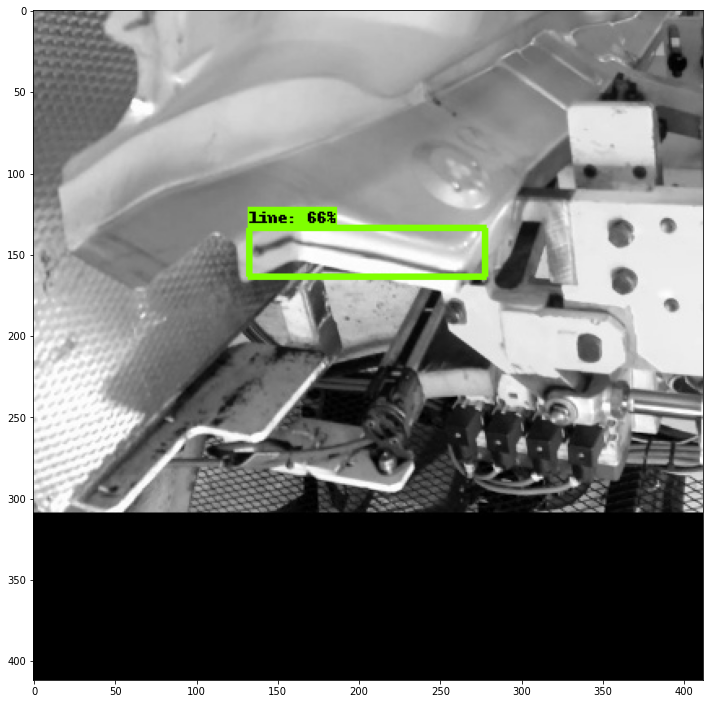

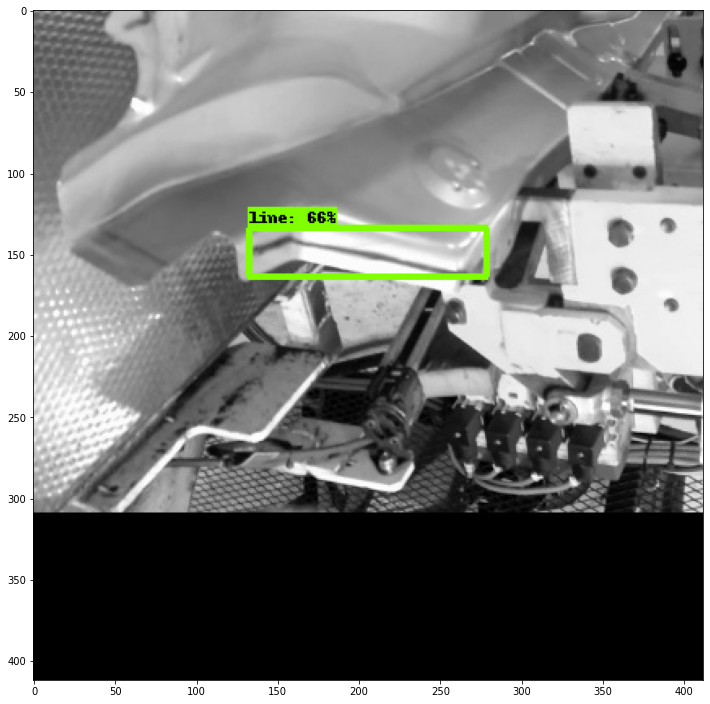

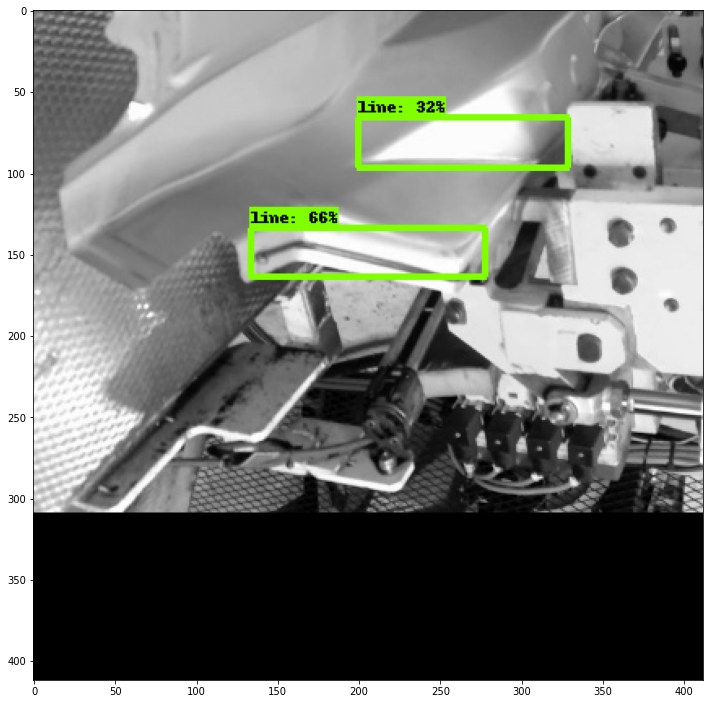

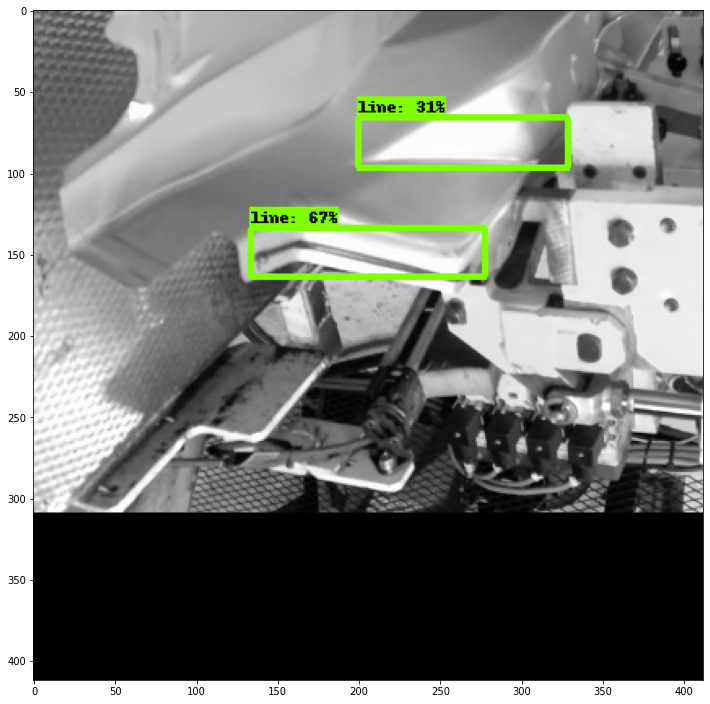

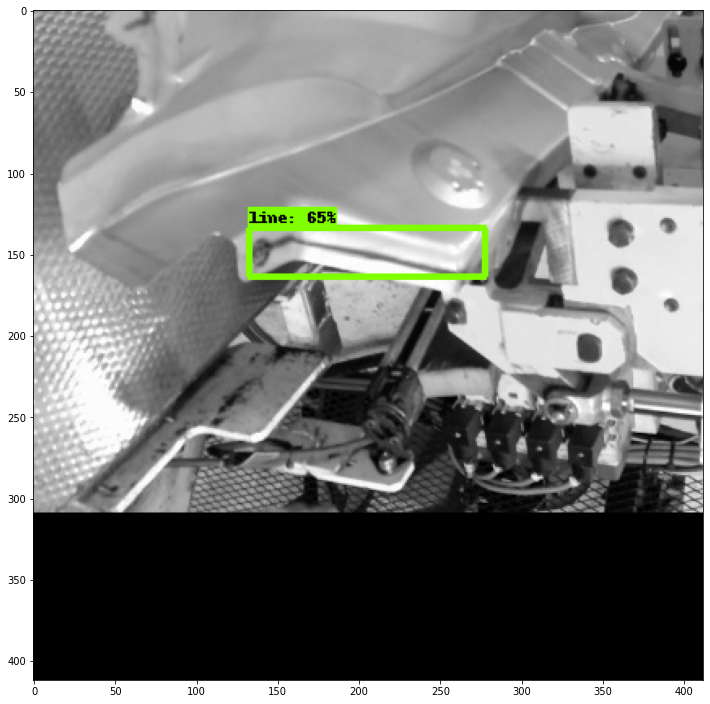

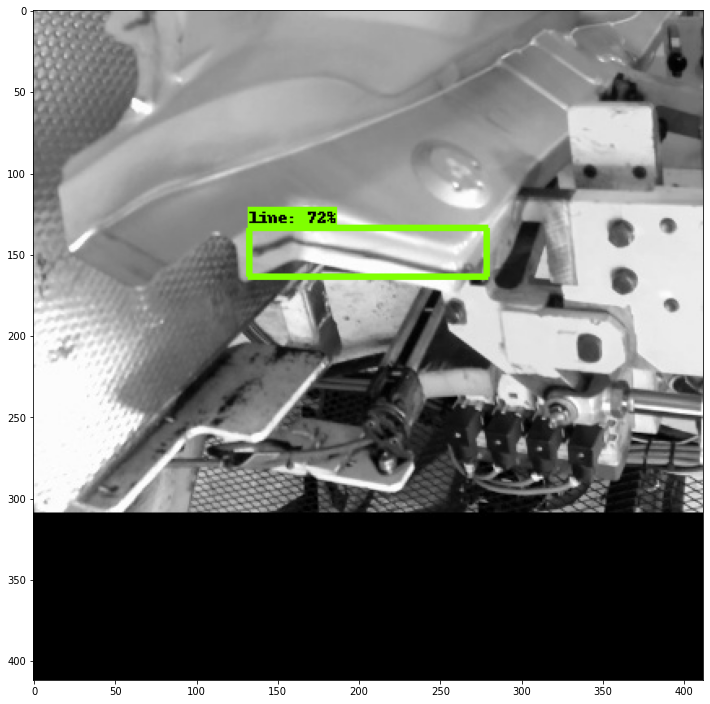

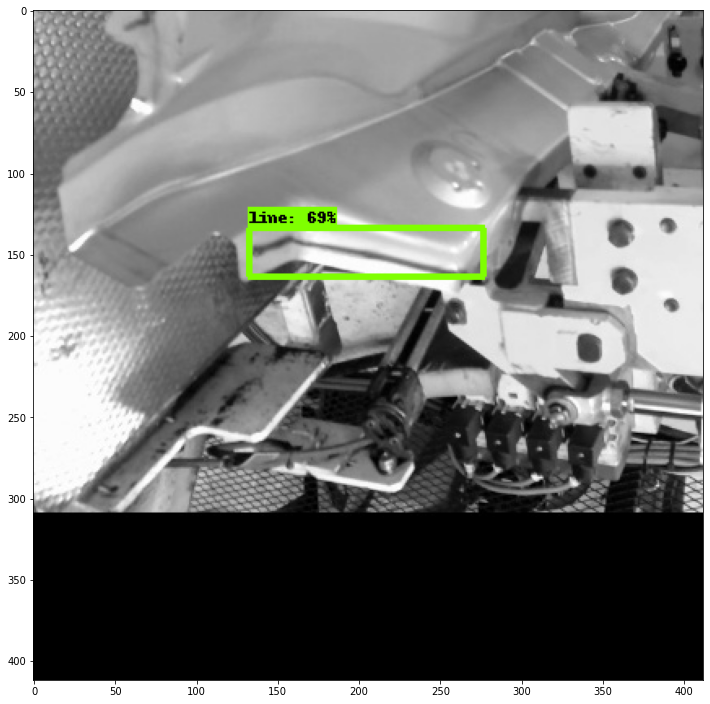

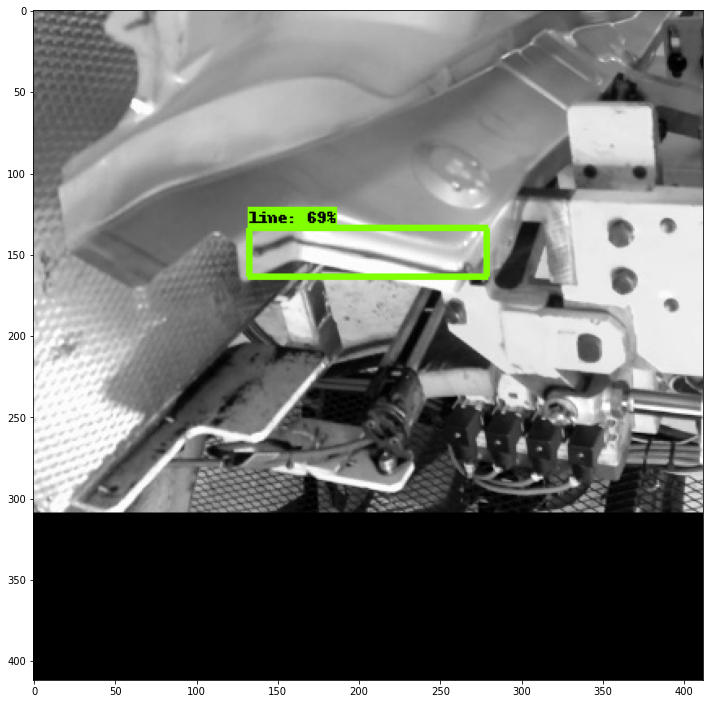

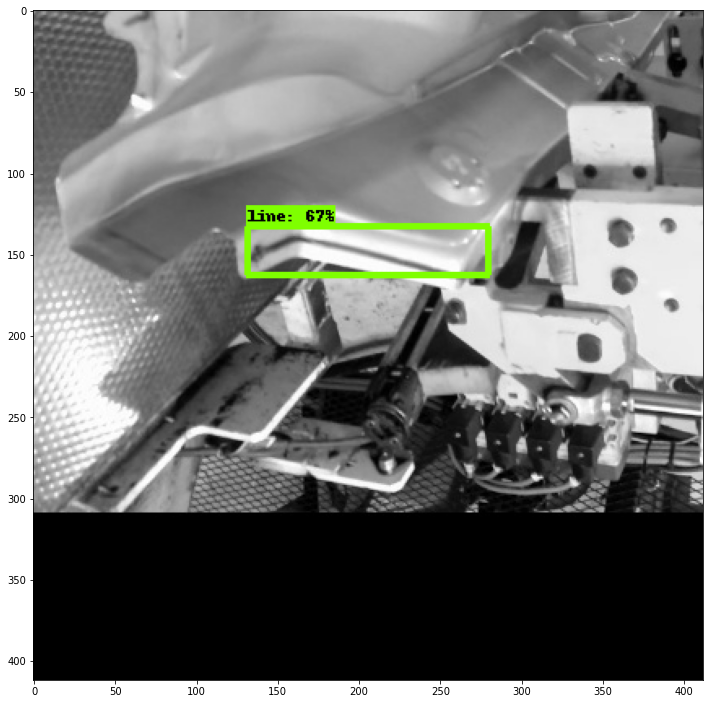

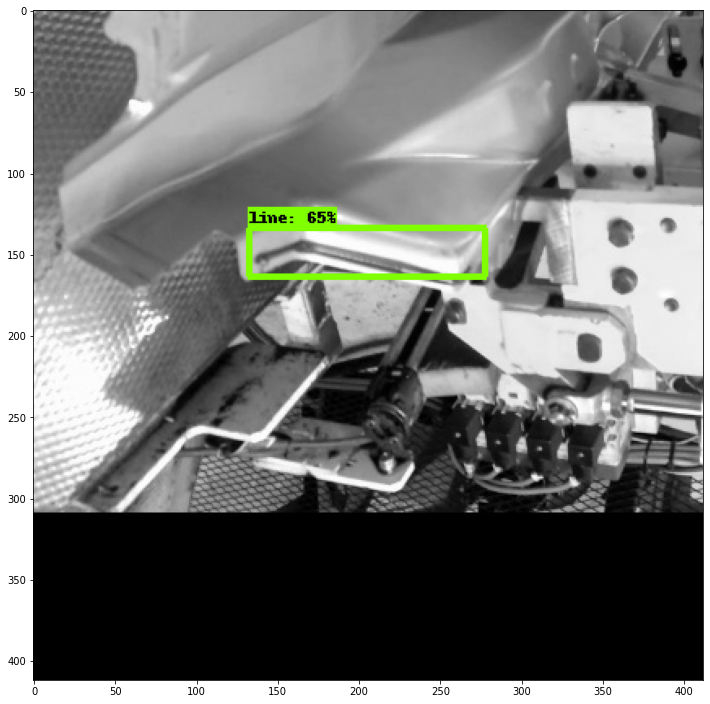

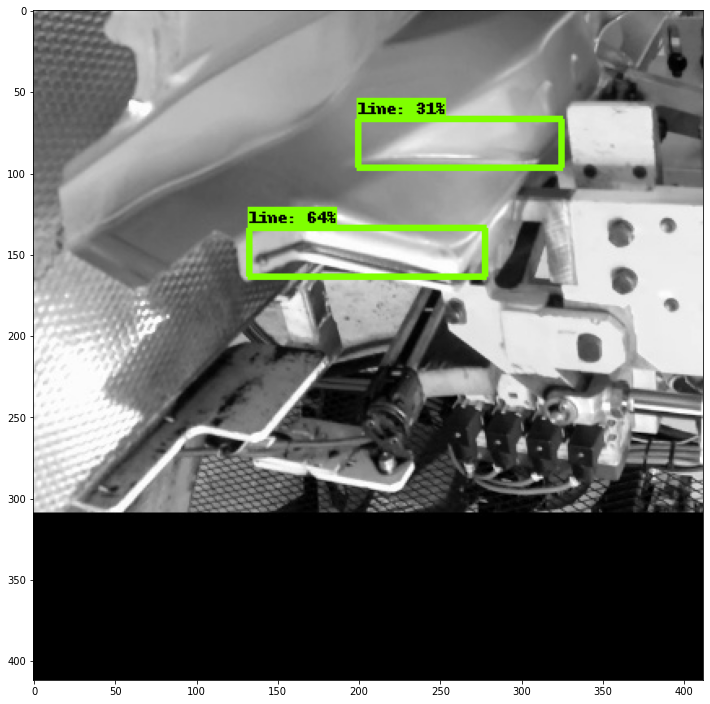

In [30]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 

PATH_TO_TEST_IMAGES_DIR = '/content/drive/MyDrive/projects/%s/preprocess/test/'%project
TEST_IMAGE_PATHS = []
for filename in os.listdir(PATH_TO_TEST_IMAGES_DIR):
    if filename.endswith(".jpg"):
      TEST_IMAGE_PATHS.append(PATH_TO_TEST_IMAGES_DIR+filename)

file_detections = {}
min_t = 0.3
# os.mkdir("/content/drive/MyDrive/projects/%s/results"%(project))
result_path = "/content/drive/MyDrive/projects/%s/results"%(project)
if not os.path.exists(result_path):
  os.mkdir(result_path)

th_result_path = "/content/drive/MyDrive/projects/%s/results/%f"%(project, min_t)
if not os.path.exists(th_result_path):
  os.mkdir(th_result_path)

for i,image_path in enumerate(TEST_IMAGE_PATHS):
  img_name = image_path.split("/")[-1]
  image_np = load_image_into_numpy_array(image_path, gray_mod=True)

  # Things to try:
  # Flip horizontally
  # image_np = np.fliplr(image_np).copy()

  # Convert image to grayscale
  # image_np = np.tile(
  #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

  print("Predicting Img: ", i)

  input_tensor = tf.convert_to_tensor(
      np.expand_dims(image_np, 0), dtype=tf.float32)
  detections, predictions_dict, shapes = detect_fn(input_tensor)

  label_id_offset = 1
  image_np_with_detections = image_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=min_t,
        agnostic_mode=False,
  )

  plt.figure(figsize=(12,16))
  plt.imshow(image_np_with_detections)
  plt.imsave('/content/drive/MyDrive/projects/%s/results/%f/%s'%(project,min_t,img_name),image_np_with_detections )
  file_detections[img_name] = {
      "detection_boxes": detections['detection_boxes'][0].numpy().tolist(),
      "detection_classes": (detections['detection_classes'][0].numpy() + label_id_offset).astype(int).tolist(),
      "detection_scores": detections['detection_scores'][0].numpy().tolist()
  }

import json
with open('/content/drive/MyDrive/projects/%s/results/summarize.json'%(project), 'w') as outfile:
    json.dump(file_detections, outfile)
